## Imports

In [ ]:
import numpy as np
import torch
import gensim.downloader as api
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier

from tqdm import tqdm
import nltk
nltk.download('punkt_tab')
from nltk.help import upenn_tagset
from nltk.corpus import stopwords
from tensorflow.keras.datasets import imdb
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore")

import re
from collections import Counter
from scipy.stats import uniform
from statistics import mode

import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

import time
import os

2024-12-15 18:26:52.779426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-15 18:26:52.862118: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-15 18:26:52.862133: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-15 18:26:52.882920: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 18:26:53.322168: W tensorflow/stream_executor/platform/de

## Preliminaries

In [ ]:
class DataPreprocessor:

    stop_words = set(stopwords.words("english"))

    @staticmethod
    def fetch_data(num_words):
        """
        Fetches the IMDB dataset, splits the data into training, testing, and development sets,
        and calculates the average review length across the dataset.
        """
        (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)
        X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

        # Calculate the overall average review length
        total_length = sum(len(review) for review in X_train) + sum(len(review) for review in X_dev) + sum(len(review) for review in X_test)
        total_count = len(X_train) + len(X_dev) + len(X_test)
        average_length = total_length / total_count

        word_index = tf.keras.datasets.imdb.get_word_index()
        index2word = dict((i + 3, word) for (word, i) in word_index.items())
        index2word[0] = '[pad]'
        index2word[1] = '[bos]'
        index2word[2] = '[oov]'

        X_train = np.array([' '.join([index2word[idx] for idx in text]) for text in X_train])
        X_test = np.array([' '.join([index2word[idx] for idx in text]) for text in X_test])
        X_dev = np.array([' '.join([index2word[idx] for idx in text]) for text in X_dev])
        return (X_train, y_train), (X_test, y_test), (X_dev, y_dev), average_length

    @staticmethod
    def preprocess_data(X):
        """
        Preprocesses the text data by cleaning, tokenizing, and lemmatizing the words
        based on their parts of speech to improve the quality of the input data.
        """
        # Helper function for better lemmatization using POS tags
        def nltk_pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:
                return None

        lemmatizer = WordNetLemmatizer()
        tagger = PerceptronTagger()
        docs = []

        for doc in tqdm(X, desc="Preprocessing data"):

            # Remove non-word (special) characters such as punctuation etc
            document = re.sub(r'\W', ' ', str(doc))  # lowercase w is word characters, W is non-word characters

            # Remove all single characters
            document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)  # \s+ looks for whitespace

            # Substitute multiple spaces with single space
            document = re.sub(r'\s+', ' ', document, flags=re.I)

            # Convert to Lowercase
            document = document.lower()

            # Split the document based on whitespaces (--> List of words)
            document = document.split()

            # Get POS tags to improve lemmatization
            doc_pos = [x[1] for x in tagger.tag(document)]

            # Lemmatization
            document = [
                lemmatizer.lemmatize(token, pos=nltk_pos_tagger(pos_tag)) if nltk_pos_tagger(pos_tag) is not None else lemmatizer.lemmatize(token)
                for token, pos_tag in zip(document, doc_pos)
            ]

            # Append all documents into a list 'docs'
            docs.append(document)
        return docs

    @staticmethod
    def build_vocab(X_tokenized, max_words=100000):
        """
        Builds a vocabulary with the most common tokens in the dataset.
        """
        all_tokens = [token for sentence in X_tokenized for token in sentence]
        token_counts = Counter(all_tokens)

        # Initialize vocabulary with special tokens <pad> and <unk>
        vocab = {"<pad>": 0, "<unk>": 1}

        # Sort tokens by frequency in descending order and add to vocab starting from 2
        for i, (token, _) in enumerate(token_counts.most_common(max_words), start=2):
            vocab[token] = i

        return vocab

    @staticmethod
    def encode_and_pad(X_tokenized, vocab, max_length=250):
        """
        Encodes and pads tokenized sentences using the vocabulary.
        """
        def encode_sentence(sentence):
            encoded = [vocab.get(token, vocab["<unk>"]) for token in sentence]
            return encoded[:max_length] + [vocab["<pad>"]] * max(0, max_length - len(encoded))

        return np.array([encode_sentence(sentence) for sentence in X_tokenized], dtype=np.int32)

    @staticmethod
    def prepare_embedding_matrix(vocab, word2vec_model, embedding_dim=300, max_words=100000):
        """
        Prepares the embedding matrix for the vocabulary using a pre-trained Word2Vec model.
        """
        embedding_matrix = np.zeros((max_words + 2, embedding_dim))  # +2 for <pad> and <unk>
        count = 0
        for word, i in vocab.items():
            if i > max_words:
                continue
            try:
                embedding_matrix[i] = word2vec_model[word]
                count += 1
            except KeyError:
                pass
        print(f"Number of words with embeddings: {count}")
        return embedding_matrix

    @staticmethod
    def prepare_data_loaders(train_data, val_data, test_data, y_train, y_val, y_test, batch_size=64):
        """
        Prepares PyTorch DataLoaders for training, validation, and testing.
        """
        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(train_data, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)

        X_val_tensor = torch.tensor(val_data, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)

        X_test_tensor = torch.tensor(test_data, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        # Create PyTorch DataLoaders
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

    @staticmethod
    def generate_embeddings(X, model, embedding_dim = 300):
        """
        Generates word embeddings for the given documents using a pre-trained word embedding model.
        Each document is represented as the average of its word vectors.
        """
        embeddings = []
        for example in X:
            words = [word for word in example if word in model and word not in DataPreprocessor.stop_words]
            if not words:
                return np.zeros(embedding_dim)
            word_vectors = np.array([model[word] for word in words])
            embeddings.append(word_vectors.mean(axis=0))

        return embeddings

In [ ]:
class Report:

    @staticmethod
    def plot_training_history(history):
        # Plotting loss
        plt.figure()
        plt.plot(history['train_loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Plotting accuracy
        plt.figure()
        plt.plot(history['train_accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        # Plotting F1 score
        plt.figure()
        plt.plot(history['train_f1_score'], label='Training F1 Score')
        plt.plot(history['val_f1_score'], label='Validation F1 Score')
        plt.title('F1 Score Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.show()


    @staticmethod
    def display_metrics_scores(estimators, classes, datasets):
        """
        Displays the evaluation metrics (precision, recall, F1, PR-AUC) for multiple classifiers across
        different data subsets (Train, Dev, Test) in a styled table format.
        """
        # def style_results(results, subset_name):
        #     combined_df = pd.concat(results, ignore_index=True)
        #     styled = combined_df.style.set_properties(
        #         subset=pd.IndexSlice[combined_df['Classifier'].duplicated(keep='first') == False, :],
        #         **{'border-top': '3px solid black'}
        #     ).hide_index()
        #     return styled
        def style_results(results, subset_name):
            combined_df = pd.concat(results, ignore_index=True)

            # Set the style and hide the index
            styled = combined_df.style.set_properties(
                subset=pd.IndexSlice[combined_df['Classifier'].duplicated(keep='first') == False, :],
                **{'border-top': '3px solid black'}
            ).set_table_styles([
                {'selector': 'th', 'props': [('text-align', 'center')]},  # Center-align header
                {'selector': 'td', 'props': [('text-align', 'center')]},  # Center-align data cells
                {'selector': 'index', 'props': [('display', 'none')]}  # Hide index column
            ])

            return styled

        # Run evaluation and store results in separate tables for each subset
        train_results = []
        dev_results = []
        test_results = []

        for name, estimator in estimators.items():
            results_df = Report._evaluate_classifier(estimator, datasets, classes, name)
            train_results.append(results_df[results_df['Subset'] == 'Train'])
            dev_results.append(results_df[results_df['Subset'] == 'Dev'])
            test_results.append(results_df[results_df['Subset'] == 'Test'])

        # Display the styled tables for each subset
        styled_train_results = style_results(train_results, 'Train')
        styled_dev_results = style_results(dev_results, 'Dev')
        styled_test_results = style_results(test_results, 'Test')
        display(styled_train_results)
        print()
        display(styled_dev_results)
        print()
        display(styled_test_results)


    @staticmethod
    def _evaluate_classifier(clf, datasets, classes, classifier_name):
        all_results = []

        for subset_name, (subset_data, y) in datasets.items():
            X = subset_data[classifier_name]

            y_pred = clf.predict(X)
            y_scores = clf.predict_proba(X)

            # Calculate per-class metrics and macro-average metrics
            metrics, macro_metrics = Report._calculate_metrics(y, y_pred, y_scores, classes)

            # Append the macro-average metrics as a single row at the start of each subset
            all_results.append({
                'Classifier': classifier_name,
                'Subset': subset_name,
                'Class': 'Macro Average',
                **macro_metrics,
                'Precision': '', 'Recall': '', 'F1': '', 'PR-AUC': ''  # Empty placeholders for class-specific columns
            })

            # Append each class's metrics as separate rows
            for cls, cls_metrics in metrics.items():
                all_results.append({
                    'Classifier': classifier_name,
                    'Subset': subset_name,
                    'Class': cls,
                    'Macro Precision': '', 'Macro Recall': '', 'Macro F1': '', 'Macro PR-AUC': '',  # Empty placeholders
                    **cls_metrics
                })

        return pd.DataFrame(all_results)


    @staticmethod
    def _calculate_metrics(y_true, y_pred, y_scores, classes):
        metrics = {}
        for idx, cls in enumerate(classes):
            binary_y_true = (y_true == cls).astype(int)

            precision = precision_score(y_true, y_pred, pos_label=cls, average='binary')
            recall = recall_score(y_true, y_pred, pos_label=cls, average='binary')
            f1 = f1_score(y_true, y_pred, pos_label=cls, average='binary')

            precisions, recalls, thresholds = precision_recall_curve(binary_y_true, y_scores[:, idx])
            pr_auc = auc(recalls, precisions)
            metrics[cls] = {
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'PR-AUC': pr_auc
            }

        macro_metrics = {
            'Macro Precision': precision_score(y_true, y_pred, average='macro'),
            'Macro Recall': recall_score(y_true, y_pred, average='macro'),
            'Macro F1': f1_score(y_true, y_pred, average='macro'),
            'Macro PR-AUC': sum(metrics[cls]['PR-AUC'] for cls in classes) / len(classes)
        }

        return metrics, macro_metrics

    def display_confusion_matrix(estimators, datasets, classes):
        """
        Displays the confusion matrix for each classifier across different data subsets
        (Train, Dev, Test) in a heatmap format.
        """
        for name, estimator in estimators.items():
            for subset_name, (subset_data, y_true) in datasets.items():
                X = subset_data[name]

                y_pred = estimator.predict(X)

                cm = confusion_matrix(y_true, y_pred, labels=classes)

                plt.figure(figsize=(8, 6))
                sns.heatmap(cm, annot=True, fmt="d", cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=classes, yticklabels=classes)
                plt.xlabel("Predicted Label")
                plt.ylabel("True Label")
                plt.title(f"Confusion Matrix for {name} - {subset_name} Set")
                plt.show()

## Stacked CNN

In [ ]:
class MultikernelCNN(nn.Module):
    def __init__(self, input_dim, n_classes, filters, max_words, n_values, stacks, dropout_prob, matrix_embeddings=None):
        """
        Parameterized Multi-Kernel CNN
        - input_dim: Dimension of the embedding vectors
        - n_classes: Number of output classes
        - filters: Number of filters in each convolutional layer
        - max_words: Vocabulary size
        - n_values: List of n-gram sizes to use (e.g., [2, 3, 4])
        - stacks: Number of stacked convolutional layers for each n-gram
        - matrix_embeddings: Optional pre-trained embedding matrix
        """
        super(MultikernelCNN, self).__init__()

        self.input_dim = input_dim
        self.n_classes = n_classes
        self.filters = filters
        self.n_values = n_values
        self.stacks = stacks
        self.dropout_prob = dropout_prob

        # Embedding layer
        if matrix_embeddings is not None:
            self.embedding_layer = nn.Embedding(num_embeddings=max_words + 2, embedding_dim=self.input_dim, padding_idx=0).from_pretrained(matrix_embeddings)
            self.embedding_layer.requires_grad = False
        else:
            self.embedding_layer = nn.Embedding(num_embeddings=max_words + 2, embedding_dim=self.input_dim, padding_idx=0)
            self.embedding_layer.requires_grad = True

        # Convolutional layers dynamically based on n_values and stacks
        self.conv_blocks = nn.ModuleDict()
        for n in self.n_values:
            layers = []
            for i in range(stacks):
                in_channels = self.input_dim if i == 0 else self.filters
                layers.append(nn.Conv1d(in_channels=in_channels, out_channels=self.filters, kernel_size=n, padding='same'))
            self.conv_blocks[f"conv_{n}"] = nn.ModuleList(layers)

        self.global_max_pool = nn.AdaptiveMaxPool1d(output_size=1)
        self.output = nn.Linear(in_features=len(self.n_values) * self.filters, out_features=self.n_classes)
        self.dropout = nn.Dropout(self.dropout_prob)

    def forward(self, input):
        # Input shape: (batch_size, sequence_length)
        # Embedding layer
        x = self.embedding_layer(input.long())  # (batch_size, sequence_length, embedding_dim)
        x = self.dropout(x)  # (batch_size, sequence_length, embedding_dim)
        x = x.transpose(1, 2)  # (batch_size, embedding_dim, sequence_length)

        # Convolutional branches for each n-gram size
        conv_outputs = []
        for n in self.n_values:
            conv_layers = self.conv_blocks[f"conv_{n}"]
            residual = x
            for conv in conv_layers:
                out = F.relu(conv(residual))  # Apply convolution and activation
                out = torch.add(out, residual)   # Add residual connection
                residual = out  # Update residual for the next layer
            # Apply global max pooling
            pooled = self.global_max_pool(out)  # (batch_size, filters, 1)
            conv_outputs.append(pooled.squeeze(2))  # (batch_size, filters)

        # Concatenate pooled outputs from all n-gram branches
        x_concat = torch.cat(conv_outputs, dim=1)  # (batch_size, filters * len(n_values))
        x_concat = self.dropout(x_concat)  # Apply dropout
        logits = self.output(x_concat)  # Output layer
        return logits


## BiLSTM RNN with "Deep" Self-Attention

In [ ]:
class BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim, n_classes,dropout_prob_emb,dropout_prob_att,dropout_prob_out, hidden_dim, lstm_hidden_dim, lstm_stacks, attention_hidden_sizes,max_words, matrix_embeddings=None):
        super(BiLSTM_Attention, self).__init__()

        # dimensions
        self.input_dim = input_dim
        self.n_classes = n_classes
        self.hidden_dim = hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.lstm_stacks = lstm_stacks
        self.attention_hidden_sizes = attention_hidden_sizes
        self.max_words = max_words

        # Embedding layer
        if matrix_embeddings is not None:
            self.embeddings = nn.Embedding(num_embeddings=self.max_words + 2, embedding_dim=self.input_dim, padding_idx=0).from_pretrained(matrix_embeddings)
            self.embeddings.requires_grad = False  # Don't change the embedding matrix
        else:
            self.embeddings = nn.Embedding(num_embeddings=self.max_words + 2, embedding_dim=self.input_dim, padding_idx=0)
            self.embeddings.requires_grad = True  # Learn the embedding matrix

        # LSTM layer (replacing GRU)
        self.bilstm = nn.LSTM(input_size=self.input_dim,
                              hidden_size=self.lstm_hidden_dim,
                              num_layers=self.lstm_stacks,
                              bidirectional=True,
                              batch_first=True)

        # Dropout layer
        self.dropout_emb = nn.Dropout(dropout_prob_emb)
        self.dropout_att = nn.Dropout(dropout_prob_att)
        self.dropout_out = nn.Dropout(dropout_prob_out)

        self.deep_attention_mlp = self._build_attention_mlp(2 * lstm_hidden_dim, attention_hidden_sizes)

        # Dense layer

        self.dense1 = nn.Linear(2 * lstm_hidden_dim, self.hidden_dim)

        # Classification layer
        self.dense2 = nn.Linear(self.hidden_dim, self.n_classes)

    def _build_attention_mlp(self, input_size, hidden_sizes):
        """
        Dynamically creates the MLP layers for attention.

        Parameters:
        - input_size: int, size of the input to the MLP
        - hidden_sizes: list of int, sizes of the hidden layers

        Returns:
        - nn.Sequential, the constructed MLP
        """
        layers = []
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.Tanh())
            input_size = hidden_size
        layers.append(nn.Linear(hidden_sizes[-1], 1))  # Output layer of the MLP
        return nn.Sequential(*layers)

    def forward(self, input):
        # Input shape: (batch_size, sequence_length)

        # Embedding layer
        x = self.embeddings(input.long())  # (batch_size, sequence_length, embedding_dim)

        # Dropout embeddings
        x = self.dropout_emb(x)
        # x = x.unsqueeze(1)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.bilstm(x)  # lstm_out (batch_size, sequence_length, 2*lstm_hidden_dim)
                                               # h_n and c_n (2, batch_size, lstm_hidden_dim)

        # Attention MLP
        attention_scores = self.deep_attention_mlp(lstm_out)  # (batch_size, sequence_length, 1)

        # Softmax to get the attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, sequence_length, 1)

        # Weigh the history with the attention weights
        attended_output = torch.sum(lstm_out * attention_weights, dim=1)  # (batch_size, 2*lstm_hidden_dim)

        # Dropout after the attended output
        x = self.dropout_att(attended_output) # (batch_size, 2*lstm_hidden_dim)

        # Dense layer 1
        x = F.relu(self.dense1(x))  # (batch_size, hidden_dim)

        # Dropout
        x = self.dropout_out(x)  # (batch_size, hidden_dim)

        # Output layer
        logits = self.dense2(x)  # (batch_size, n_classes)

        return logits

# MLP Classifier

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_size=500, hidden_sizes=[512, 256], output_size=2, dropout_probs=0.5):
        """
        Initializes the MLPModel with configurable hidden layers and dropout probabilities.

        Parameters:
        - input_size: int, size of the input vector (default: 500)
        - hidden_sizes: list of int, sizes of the hidden layers (default: [512, 256])
        - output_size: int, size of the output layer (default: 20)
        - dropout_probs: float or list of floats, dropout probability for each layer
          (default: 0.5, or specify one value per hidden layer)
        """
        super(MLPModel, self).__init__()

        # Ensure dropout_probs is a list (one value per hidden layer)
        if isinstance(dropout_probs, float):
            dropout_probs = [dropout_probs] * len(hidden_sizes)
        elif len(dropout_probs) != len(hidden_sizes):
            raise ValueError("dropout_probs must be a single float or a list of the same length as hidden_sizes")

        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # Input to the first hidden layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.dropouts.append(nn.Dropout(dropout_probs[0]))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.dropouts.append(nn.Dropout(dropout_probs[i]))

        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, input):
        """
        Forward pass of the MLPModel.

        Parameters:
        - input: torch.Tensor, shape (batch_size, input_size)

        Returns:
        - logits: torch.Tensor, shape (batch_size, output_size)
        """
        x = input
        for layer, dropout in zip(self.layers, self.dropouts):
            x = F.relu(layer(x))
            x = dropout(x)
        logits = self.output_layer(x)
        return logits

In [ ]:
class Classifier_Wrapper:
    def __init__(self, model, optimizer, criterion, device, epochs):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.epochs = epochs

    def fit(self, data_loader):
        history = {'loss': []}
        self.model.to(self.device)

        for epoch in range(self.epochs):
            # Training phase
            self.model.train()  # Set the model to training mode
            running_loss = 0.0  # Track the loss for the epoch

            for batch in data_loader:
                features, labels = batch
                features = features.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(features)
                loss = self.criterion(outputs, labels)  # Compute loss
                loss.backward()  # Backward pass
                self.optimizer.step()  # Update model parameters

                running_loss += loss.item()

            # Print average loss for the epoch
            epoch_loss = running_loss / len(data_loader)
            history['loss'].append(epoch_loss)
            print(f"Epoch [{epoch + 1}/{self.epochs}] - Training Loss: {epoch_loss:.4f}")


    def predict(self, test_loader):
        self.model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():  # No gradient calculation during evaluation
            for batch in test_loader:
                features, labels = batch
                features = features.to(self.device)
                labels = labels.to(self.device)

                # Forward pass
                outputs = self.model(features)
                _, predicted = torch.max(outputs, 1)  # Get predicted class
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Collect all labels and predictions for F1 score
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        return np.array(all_predictions)


    def predict_proba(self, test_loader):
        self.model.eval()  # Set the model to evaluation mode
        all_probabilities = []

        with torch.no_grad():  # No gradient calculation during evaluation
            for batch in test_loader:
                features, labels = batch
                features = features.to(self.device)

                # Forward pass
                outputs = self.model(features)
                probabilities = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

                # Collect probabilities
                all_probabilities.extend(probabilities.cpu().numpy())

        return np.array(all_probabilities)

## Utils

In [ ]:
class Utils:
    def train_and_evaluate(model, optimizer, criterion, device, epochs, train_loader, test_loader, title='Test'):
        """
        Train and evaluate a PyTorch model.

        Parameters:
        - model: nn.Module, the model to train
        - train_loader: DataLoader, DataLoader for training data
        - test_loader: DataLoader, DataLoader for testing/validation data
        - optimizer: Optimizer, the optimizer to use for training
        - criterion: Loss function
        - epochs: int, number of epochs to train
        - device: torch.device, device to train on (CPU or GPU)

        Returns:
        - test_accuracy: float, accuracy on the test set
        - test_f1: float, F1 score on the test set
        """
        model.to(device)

        for epoch in range(epochs):
            # Training phase
            model.train()  # Set the model to training mode
            running_loss = 0.0  # Track the loss for the epoch

            for batch in train_loader:
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                outputs = model(features)
                loss = criterion(outputs, labels)  # Compute loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update model parameters

                running_loss += loss.item()

            # Print average loss for the epoch
            epoch_loss = running_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {epoch_loss:.4f}')

        # Evaluation phase
        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():  # No gradient calculation during evaluation
            for batch in test_loader:
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(features)
                _, predicted = torch.max(outputs, 1)  # Get predicted class
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Collect all labels and predictions for F1 score
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        test_accuracy = correct / total
        test_f1 = f1_score(all_labels, all_predictions, average='macro')

        print(f'{title} Accuracy: {test_accuracy:.4f}')
        print(f'{title} F1 Score: {test_f1:.4f}')

        return test_accuracy, test_f1

    @staticmethod
    def train_and_validate(model, optimizer, criterion, device, epochs, train_loader, val_loader):
        """
        Train and validate a PyTorch model, tracking metrics and saving the best model.

        Parameters:
        - model: nn.Module, the model to train
        - train_loader: DataLoader, DataLoader for training data
        - val_loader: DataLoader, DataLoader for validation data
        - optimizer: Optimizer, the optimizer to use for training
        - criterion: Loss function
        - epochs: int, number of epochs to train
        - device: torch.device, device to train on (CPU or GPU)

        Returns:
        - history: dict, containing training and validation losses, accuracy, and F1 scores
        - best_model_path: str, path to the saved best model
        """
        model.to(device)

        # Initialize history and best model tracking
        history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], 'train_f1_score': [], 'val_f1_score': []}
        best_rnn_val_loss = float("inf")  # Initialize to a high value
        best_model_path = None

        start_training_time = time.time()

        for epoch in range(epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            train_outputs = []
            train_labels = []

            for batch in train_loader:
                features, labels = batch
                features, labels = features.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(features)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                train_outputs.append(outputs)
                train_labels.append(labels)

            # Concatenate all outputs and labels for metrics calculation
            train_outputs = torch.cat(train_outputs)
            train_labels = torch.cat(train_labels)
            train_classes = train_labels
            train_predicted_classes = torch.argmax(train_outputs, dim=1)

            # Calculate training metrics
            train_loss = running_loss / len(train_loader)
            train_accuracy = accuracy_score(train_classes.cpu(), train_predicted_classes.cpu())
            train_f1_score = f1_score(train_classes.cpu(), train_predicted_classes.cpu(), average='weighted')

            # Update history
            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_accuracy)
            history['train_f1_score'].append(train_f1_score)

            print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1_score:.4f}")

            # Validation phase
            model.eval()
            val_running_loss = 0.0
            all_outputs = []
            all_labels = []

            with torch.no_grad():
                for features, labels in val_loader:
                    features, labels = features.to(device), labels.to(device)
                    outputs = model(features)
                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item()
                    all_outputs.append(outputs)
                    all_labels.append(labels)

            # Concatenate all outputs and labels for metrics calculation
            all_outputs = torch.cat(all_outputs)
            all_labels = torch.cat(all_labels)
            true_classes = all_labels
            predicted_classes = torch.argmax(all_outputs, dim=1)

            # Calculate validation metrics
            val_loss = val_running_loss / len(val_loader)
            val_accuracy = accuracy_score(true_classes.cpu(), predicted_classes.cpu())
            val_f1 = f1_score(true_classes.cpu(), predicted_classes.cpu(), average='weighted')

            # Update history
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)
            history['val_f1_score'].append(val_f1)

            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

            # Save checkpoint if validation loss improves
            if val_loss < best_rnn_val_loss:
                best_val_loss = val_loss
                new_model_path = f'mlp_best_model_epoch_{epoch+1}.pth'

                # Remove the previous best model
                if best_model_path is not None:
                    os.remove(best_model_path)

                # Save the new best model
                torch.save(model.state_dict(), new_model_path)
                best_model_path = new_model_path

        end_training_time = time.time()
        print(f"Training complete! Total time: {end_training_time - start_training_time:.2f} seconds")

        return history, best_model_path

## Load and preprocess data

**IMDb Movie Reviews dataset**

Dataset Composition

- Content: The dataset contains movie reviews from IMDb, which are labeled as either positive or negative.
- Labels: It's a binary classification dataset, with labels 0 (negative) and 1 (positive).
- Data Split: The dataset has 25,000 reviews for training and 25,000 for testing, ensuring a balanced split of positive and negative reviews in each set. We further divide the testing data into a development (or validation) set and a final test set, each containing 12,500 reviews.

In [ ]:
(X_train, y_train), (X_test, y_test), (X_dev, y_dev), average_length = DataPreprocessor.fetch_data(num_words=10000)

# Average review length
print(f"Average review length: {average_length:.2f} words")

# Randomly select 5 examples to display
random_indices = np.random.randint(0, len(X_train)-1, size=5)
selected_examples = [X_train[i] for i in random_indices]
selected_labels = [y_train[i] for i in random_indices]

print("\nRandomly selected examples")

for i, (example, label) in enumerate(zip(selected_examples, selected_labels)):
    print(f"{i+1}. Review: {example[:150]}...")
    print(f"   Sentiment: {'Positive' if label == 1 else 'Negative'}\n")

Average review length: 234.76 words

Randomly selected examples
1. Review: [bos] i have zero interest rap and in ghetto culture i'm white and like classic rock however that did not stop me from [oov] this fantastic comedy its...
   Sentiment: Positive

2. Review: [bos] loved this show smart acting smart dialog great storyline with real people please bring it back or make it available online really miss it hope ...
   Sentiment: Positive

3. Review: [bos] if i didn't know any better it almost seems like it was staged but it wasn't it was set up perfectly and how they got all of that footage is ama...
   Sentiment: Positive

4. Review: [bos] from around the time europe began fighting world war ii until the [oov] end hollywood with significant [oov] from the government made tons of mo...
   Sentiment: Negative

5. Review: [bos] this batman movie isn't quite as good as batman mask of the phantasm and batman and mr freeze [oov] but it is still a good installment to the ba...
   Sentiment: P

We use the pre-trained `word2vec-google-news-300` model from Gensim's API to obtain 300-dimensional word embeddings for the words in our dataset.

In [ ]:
# # Step 1: Fetch and preprocess data
(X_train, y_train), (X_test, y_test), (X_dev, y_dev), avg_len = DataPreprocessor.fetch_data(num_words=10000)

# Preprocess the text data (clean and tokenize)
X_train_preprocessed = DataPreprocessor.preprocess_data(X_train)
X_test_preprocessed = DataPreprocessor.preprocess_data(X_test)
X_dev_preprocessed = DataPreprocessor.preprocess_data(X_dev)

# y_train = y_train[:1000]
# y_test = y_test[:500]
# y_dev = y_dev[:500]

# Step 2: Build vocabulary from training data
vocab = DataPreprocessor.build_vocab(X_train_preprocessed, max_words=100000)

# Step 3: Encode and pad sentences for all datasets
train_data = DataPreprocessor.encode_and_pad(X_train_preprocessed, vocab, max_length=250)
val_data = DataPreprocessor.encode_and_pad(X_dev_preprocessed, vocab, max_length=250)
test_data = DataPreprocessor.encode_and_pad(X_test_preprocessed, vocab, max_length=250)
w2v_model = api.load("word2vec-google-news-300")

# Step 4: Prepare the embedding matrix using a pre-trained Word2Vec model
embedding_matrix = DataPreprocessor.prepare_embedding_matrix(vocab, w2v_model, embedding_dim=300)

# Step 5: Prepare PyTorch DataLoaders
train_loader_rnn, val_loader_rnn, test_loader_rnn = DataPreprocessor.prepare_data_loaders(
    train_data, val_data, test_data, y_train, y_dev, y_test, batch_size=256
)

Preprocessing data: 100%|██████████| 12500/12500 [01:10<00:00, 178.19it/s]


Number of words with embeddings: 8576


## Training and Testing

### **Classification with Stacked CNN Classifier**

**Experiment Setup: Initial Testing with Arbitrary Hyperparameters**

In this experiment, we aim to evaluate the performance of our Stacked CNN classifier. To start, we set arbitrary hyperparameter values for the Stacked CNN classifier. This initial testing allows us to observe baseline performance and helps us identify potential adjustments for further tuning. Subsequent steps will involve tuning these parameters for optimal performance.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Initialize the model
model_cnn = MultikernelCNN(
    input_dim=300,      # Embedding dimension
    n_classes=len(np.unique(y_train)),  # Number of classes
    filters=300,        # Number of filters per convolution
    max_words=30000,    # Vocabulary size
    n_values=[2, 3, 4], # n-gram sizes
    stacks=2,           # Number of stacked layers per n-gram
    dropout_prob=0.2,    # Dropout probability
    matrix_embeddings=torch.tensor(embedding_matrix, dtype = torch.float)
)
print(model_cnn)

MultikernelCNN(
  (embedding_layer): Embedding(100002, 300)
  (conv_blocks): ModuleDict(
    (conv_2): ModuleList(
      (0-1): 2 x Conv1d(300, 300, kernel_size=(2,), stride=(1,), padding=same)
    )
    (conv_3): ModuleList(
      (0-1): 2 x Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same)
    )
    (conv_4): ModuleList(
      (0-1): 2 x Conv1d(300, 300, kernel_size=(4,), stride=(1,), padding=same)
    )
  )
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (output): Linear(in_features=900, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
model_cnn.to(device)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizer and loss function
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Number of epochs
epochs=20

In [ ]:
# Train and evaluate the CNN Classifier (Before hyperparameter tuning)
test_accuracy, macro_f1 = Utils.train_and_evaluate(model_cnn, optimizer, criterion, device, epochs, train_loader_rnn, test_loader_rnn)

Epoch [1/20], Average Loss: 0.4631
Epoch [2/20], Average Loss: 0.3132
Epoch [3/20], Average Loss: 0.2711
Epoch [4/20], Average Loss: 0.2346
Epoch [5/20], Average Loss: 0.2010
Epoch [6/20], Average Loss: 0.1603
Epoch [7/20], Average Loss: 0.1410
Epoch [8/20], Average Loss: 0.1199
Epoch [9/20], Average Loss: 0.0903
Epoch [10/20], Average Loss: 0.0741
Epoch [11/20], Average Loss: 0.0630
Epoch [12/20], Average Loss: 0.0481
Epoch [13/20], Average Loss: 0.0484
Epoch [14/20], Average Loss: 0.0408
Epoch [15/20], Average Loss: 0.0367
Epoch [16/20], Average Loss: 0.0328
Epoch [17/20], Average Loss: 0.0255
Epoch [18/20], Average Loss: 0.0310
Epoch [19/20], Average Loss: 0.0252
Epoch [20/20], Average Loss: 0.0257
Test Accuracy: 0.8869
Test F1 Score: 0.8866


**Hyperparameter Tuning for Stacked CNN**

The hyperparameter tuning is performed using a grid search approach.

**Hyperparameters Tuned**
- **Filters (`filters`)**: Number of convolutional filters applied per kernel.
- **n-Gram Sizes (`n_values`)**: Specifies the range of n-gram sizes used in convolutional kernels.
- **Number of Stacked Layers (`stacks`)**: Defines how many convolutional layers are stacked for each n-gram size.
- **Dropout Probability (`dropout_prob`)**: Dropout rate applied during training to prevent overfitting.
- **Learning Rate (`learning_rate`)**: Controls the step size for the optimizer during weight updates.

**Procedure**

1. **Data Preparation**:
   - Input data (pre-trained word embeddings) is transformed into tensors.
   - Data is batched using a data loader to ensure efficient feeding into the model during training.

2. **Model Initialization**:
   - The `MultikernelCNN` model is instantiated with each hyperparameter configuration from the defined search grid.

3. **Training**:
   - The model is trained for a fixed number of epochs (`epochs = 5`) using:
     - **Optimizer:** Adam, to optimize weights with adaptive learning rates.
     - **Loss Function:** Cross-entropy loss to handle classification.

4. **Evaluation**:
   - After training with each configuration, the model is evaluated on the validation set, where the **macro F1 score** is the primary evaluation metric.

The best-performing parameters are identified based on the macro F1 score on the development set. The final results include the best hyperparameters and their corresponding performance metrics.

In [ ]:
# Hyperparameter grid
param_grid = {
    "filters": [100, 300],                 # Number of filters per convolution
    "n_values": [[2, 3], [2, 3, 4]],       # n-gram sizes
    "stacks": [1, 2],                      # Number of stacked layers per n-gram
    "dropout_prob": [0.2, 0.3],            # Dropout probability
    "learning_rate": [0.01, 0.001],        # Learning rate
}

best_score = 0
best_params = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 5

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")

    # Unpack parameters
    filters = params["filters"]
    n_values = params["n_values"]
    stacks = params["stacks"]
    dropout_prob = params["dropout_prob"]
    learning_rate = params["learning_rate"]

    # Initialize the CNN model
    model_cnn = MultikernelCNN(
        input_dim=300,
        n_classes=len(np.unique(y_train)),
        filters=filters,
        max_words=30000,
        n_values=n_values,
        stacks=stacks,
        dropout_prob=dropout_prob,
        matrix_embeddings=torch.tensor(embedding_matrix, dtype=torch.float32).to(device)
    )

    model_cnn.to(device)

    # Optimizer and loss function
    optimizer = Adam(model_cnn.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    dev_accuracy, dev_macroF1_score = Utils.train_and_evaluate(
        model_cnn, optimizer, criterion, device, epochs, train_loader_rnn, val_loader_rnn, title='Validation'
    )

    # Update best parameters if current model is better
    if dev_macroF1_score > best_score:
        best_score = dev_macroF1_score
        best_params = params

print(f"Best hyperparameters: {best_params}")
print(f"Best development macro f1: {best_score:.4f}")

**Hyperparameter Tuning for Stacked CNN**

The hyperparameter tuning is performed using a random search approach. A predefined number of random samples (`n_iter = 50`) is selected from the hyperparameter space.

**Hyperparameters Tuned**
- **Filters (`filters`)**: Number of convolutional filters applied per kernel.
- **n-Gram Sizes (`n_values`)**: Specifies the range of n-gram sizes used in convolutional kernels.
- **Number of Stacked Layers (`stacks`)**: Defines how many convolutional layers are stacked for each n-gram size.
- **Dropout Probability (`dropout_prob`)**: Dropout rate applied during training to prevent overfitting.
- **Learning Rate (`learning_rate`)**: Controls the step size for the optimizer during weight updates.

**Procedure**

1. **Data Preparation**:
   - Input data (pre-trained word embeddings) is transformed into tensors.
   - Data is batched using a data loader to ensure efficient feeding into the model during training.

2. **Model Initialization**:
   - The `MultikernelCNN` model is instantiated with a randomly selected hyperparameter configuration from the defined search space.

3. **Training**:
   - The model is trained for a fixed number of epochs (`epochs = 5`) using:
     - **Optimizer:** Adam, to optimize weights with adaptive learning rates.
     - **Loss Function:** Cross-entropy loss to handle classification.

4. **Evaluation**:
   - After training, the model is evaluated on the validation set, where the **macro F1 score** is the primary evaluation metric.

The best-performing parameters are identified based on the macro F1 score on the development set. The final results include the best hyperparameters and their corresponding performance metrics.


In [ ]:
import random

param_space = {
    "filters": [300],                 # Number of filters per convolution
    "n_values": [[2],[3],[4],[2, 3], [2, 3, 4],[3,4]],       # n-gram sizes
    "stacks": [1, 2,3],                      # Number of stacked layers per n-gram
    "dropout_prob": [0.1,0.2, 0.3,0.4,0.5],            # Dropout probability
    "learning_rate": [0.01, 0.001],        # Learning rate
}

# Random search setup
n_iter = 50  # Number of random samples
best_score = 0
best_params = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 5

# Generate random combinations of parameters
param_list = [{k: random.choice(v) for k, v in param_space.items()} for _ in range(n_iter)]

for params in param_list:
    print(f"Testing parameters: {params}")

    # Unpack parameters
    filters = params["filters"]
    n_values = params["n_values"]
    stacks = params["stacks"]
    dropout_prob = params["dropout_prob"]
    learning_rate = params["learning_rate"]

    # Initialize the CNN model
    model_cnn = MultikernelCNN(
        input_dim=300,
        n_classes=len(np.unique(y_train)),
        filters=filters,
        max_words=30000,
        n_values=n_values,
        stacks=stacks,
        dropout_prob=dropout_prob,
        matrix_embeddings=torch.tensor(embedding_matrix, dtype=torch.float32).to(device)
    )

    model_cnn.to(device)

    # Optimizer and loss function
    optimizer = Adam(model_cnn.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    dev_accuracy, dev_macroF1_score = Utils.train_and_evaluate(
        model_cnn, optimizer, criterion, device, epochs, train_loader_rnn, val_loader_rnn, title='Validation'
    )

    # Update best parameters if current model is better
    if dev_macroF1_score > best_score:
        best_score = dev_macroF1_score
        best_params = params

print(f"Best hyperparameters: {best_params}")
print(f"Best development macro f1: {best_score:.4f}")

Testing parameters: {'filters': 300, 'n_values': [2, 3], 'stacks': 1, 'dropout_prob': 0.1, 'learning_rate': 0.01}
Epoch [1/5], Average Loss: 0.4801
Epoch [2/5], Average Loss: 0.3170
Epoch [3/5], Average Loss: 0.2701
Epoch [4/5], Average Loss: 0.2349
Epoch [5/5], Average Loss: 0.2021
Validation Accuracy: 0.8758
Validation F1 Score: 0.8758
Testing parameters: {'filters': 300, 'n_values': [4], 'stacks': 1, 'dropout_prob': 0.3, 'learning_rate': 0.001}
Epoch [1/5], Average Loss: 0.5421
Epoch [2/5], Average Loss: 0.3829
Epoch [3/5], Average Loss: 0.3447
Epoch [4/5], Average Loss: 0.3249
Epoch [5/5], Average Loss: 0.3073
Validation Accuracy: 0.8717
Validation F1 Score: 0.8716
Testing parameters: {'filters': 300, 'n_values': [2, 3, 4], 'stacks': 3, 'dropout_prob': 0.4, 'learning_rate': 0.01}
Epoch [1/5], Average Loss: 0.9582
Epoch [2/5], Average Loss: 0.4137
Epoch [3/5], Average Loss: 0.3843
Epoch [4/5], Average Loss: 0.3888
Epoch [5/5], Average Loss: 0.3582
Validation Accuracy: 0.8653
Validat

The CNN classifier is trained using the best hyperparameters identified during the tuning process. The model is trained over 50 epochs using the `train_and_validate` function, which monitors performance on both the training and the validation set after each epoch.

In [ ]:
# Unpack best parameters
best_cnn_filters = best_params["filters"]
best_cnn_n_values = best_params["n_values"]
best_cnn_stacks = best_params["stacks"]
best_cnn_dropout_prob = best_params["dropout_prob"]
best_cnn_learning_rate = best_params["learning_rate"]

# Initialize the CNN model with best parameters
model_cnn = MultikernelCNN(
    input_dim=300,
    n_classes=len(np.unique(y_train)),
    filters=best_cnn_filters,
    max_words=30000,
    n_values=best_cnn_n_values,
    stacks=best_cnn_stacks,
    dropout_prob=best_cnn_dropout_prob,
    matrix_embeddings=torch.tensor(embedding_matrix, dtype=torch.float32).to(device)
)

print(model_cnn)
model_cnn.to(device)

optimizer = Adam(model_cnn.parameters(), lr=best_cnn_learning_rate)
criterion = nn.CrossEntropyLoss()

# Train and validate
epochs_for_val = 50
history, best_model_path = Utils.train_and_validate(
    model_cnn, optimizer, criterion, device, epochs_for_val, train_loader_rnn, val_loader_rnn
)

print(f"Best model saved at: {best_model_path}")

MultikernelCNN(
  (embedding_layer): Embedding(100002, 300)
  (conv_blocks): ModuleDict(
    (conv_2): ModuleList(
      (0-2): 3 x Conv1d(300, 300, kernel_size=(2,), stride=(1,), padding=same)
    )
    (conv_3): ModuleList(
      (0-2): 3 x Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same)
    )
    (conv_4): ModuleList(
      (0-2): 3 x Conv1d(300, 300, kernel_size=(4,), stride=(1,), padding=same)
    )
  )
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (output): Linear(in_features=900, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch 1/50, Training Loss: 0.4761, Accuracy: 0.7614, F1 Score: 0.7614
Validation Loss: 0.3369, Accuracy: 0.8521, F1 Score: 0.8520
Epoch 2/50, Training Loss: 0.3300, Accuracy: 0.8588, F1 Score: 0.8588
Validation Loss: 0.3078, Accuracy: 0.8639, F1 Score: 0.8635
Epoch 3/50, Training Loss: 0.2893, Accuracy: 0.8802, F1 Score: 0.8802
Validation Loss: 0.2914, Accuracy: 0.8734, F1 Score: 0.8730
Epoch 4/50, Training L

**Visualization**:  
   - The training process is summarized in three performance plots:  
     - **Loss vs. Epochs**: Tracks how the training and validation loss evolve over time.  
     - **Accuracy vs. Epochs**: Shows the accuracy trends for both training and validation sets.  
     - **F1 Score vs. Epochs**: Shows the F1 score across epochs for training and validation.

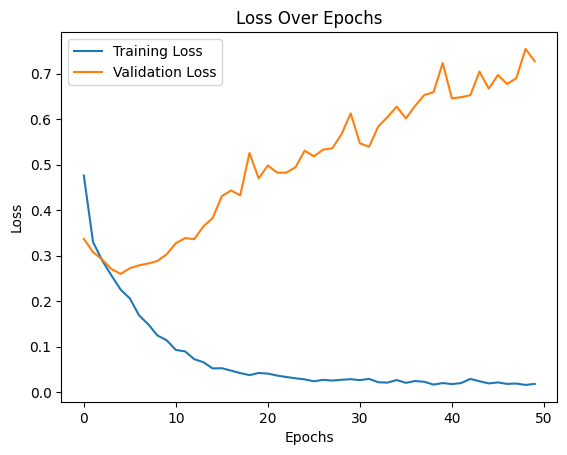

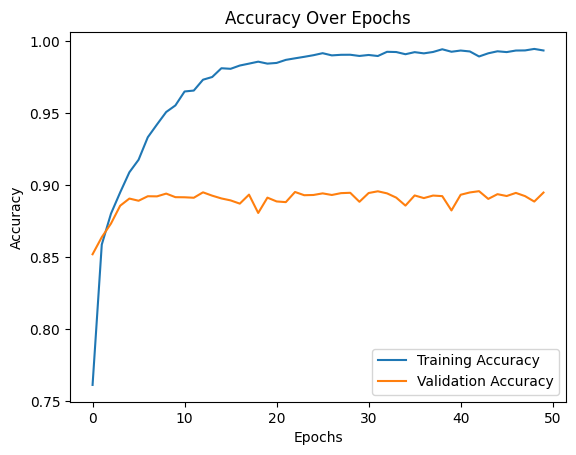

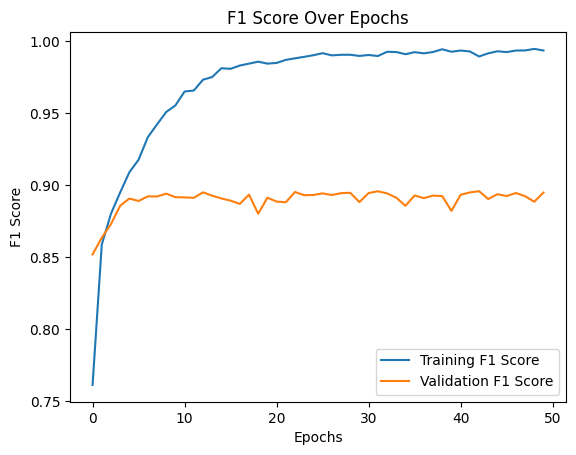

In [ ]:
Report.plot_training_history(history)

### **Classification with BiLSTM RNN Classifier**

**Experiment Setup: Initial Testing with Arbitrary Hyperparameters**

In this experiment, we aim to evaluate the performance of our BiLSTM RNN classifier. To start, we set arbitrary hyperparameter values for the BiLSTM RNN classifier. This initial testing allows us to observe baseline performance and helps us identify potential adjustments for further tuning. Subsequent steps will involve tuning these parameters for optimal performance.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Model instance
model_rnn = BiLSTM_Attention(
    input_dim=w2v_model.vector_size, # Embedding size
    n_classes=len(np.unique(y_train)),    # Number of output classes
    dropout_prob_emb=0.3,            # Embedding dropout probability
    dropout_prob_att=0.3,            # Attention dropout probability
    dropout_prob_out=0.3,            # Output dropout probability
    hidden_dim=256,                  # Dimension for the hidden dense layer
    lstm_hidden_dim=128,             # Dimension for the LSTM
    lstm_stacks=1,                   # Number of LSTM stacks
    attention_hidden_sizes=[256],    # Dimensions for the hidden layers of the Attention MLP
    max_words=100000,                # Vocabulary size
    matrix_embeddings=torch.tensor(embedding_matrix, dtype=torch.float32)  # Pretrained embeddings (w2vec)
)

print(model_rnn)
print(f"Total learnable parameters: {sum(p.numel() for p in model_rnn.parameters() if p.requires_grad)}")

BiLSTM_Attention(
  (embeddings): Embedding(100002, 300)
  (bilstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (dropout_emb): Dropout(p=0.3, inplace=False)
  (dropout_att): Dropout(p=0.3, inplace=False)
  (dropout_out): Dropout(p=0.3, inplace=False)
  (deep_attention_mlp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
  (dense1): Linear(in_features=256, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=2, bias=True)
)
Total learnable parameters: 572675


In [ ]:
model_rnn.to(device)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizer and loss function
optimizer = Adam(model_rnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Number of epochs
epochs=10

In [ ]:
# Train and evaluate the BiLSTM RNN Classifier (Before hyperparameter tuning)
test_accuracy, macro_f1 = Utils.train_and_evaluate(model_rnn, optimizer, criterion, device, epochs, train_loader_rnn, test_loader_rnn)

Epoch [1/10], Average Loss: 0.6926
Epoch [2/10], Average Loss: 0.6302
Epoch [3/10], Average Loss: 0.4879
Epoch [4/10], Average Loss: 0.4209
Epoch [5/10], Average Loss: 0.3874
Epoch [6/10], Average Loss: 0.3651
Epoch [7/10], Average Loss: 0.3505
Epoch [8/10], Average Loss: 0.3558
Epoch [9/10], Average Loss: 0.3356
Epoch [10/10], Average Loss: 0.3207
Test Accuracy: 0.8440
Test F1 Score: 0.8438


**Hyperparameter Tuning for BiLSTM RNN**

The hyperparameter tuning is performed using a grid search approach.

**Hyperparameters Tuned**
- **Embedding Dropout Probability (`dropout_prob_emb`)**: Dropout for the embedding layer.
- **Attention Dropout Probability (`dropout_prob_att`)**: Dropout applied during the attention mechanism.
- **Output Dropout Probability (`dropout_prob_out`)**: Dropout applied during the final output layer.
- **Dense Hidden Layer Size (`hidden_dim`)**: Determines the dimension of the fully connected dense layer after the LSTM.
- **LSTM Hidden Dimension (`lstm_hidden_dim`)**: Specifies the dimension of the hidden LSTM layer.
- **LSTM Stacks (`lstm_stacks`)**: Defines the number of LSTM layers.
- **Attention Hidden Sizes (`attention_hidden_sizes`)**: Architecture of the attention MLP, specifying the number of layers and their sizes.
- **Learning Rate (`learning_rate`)**: Step size for the optimizer during weight updates.

**Procedure**

1. **Data Preparation**:
   - Input data (pre-trained word embeddings) is converted into tensors and padded/truncated to ensure uniform sequence lengths.
   - A data loader is used to batch the data and feed it into the model during training.

2. **Model Initialization**:
   - The `BiLSTM_Attention` model is instantiated with the current hyperparameter configuration.

3. **Training**:
   - The model is trained for a fixed number of epochs (`epochs = 5`) using:
     - **Optimizer:** Adam, to optimize the weights based on gradients.
     - **Loss Function:** Cross-entropy loss.

4. **Evaluation**:
   - After each training configuration, the model is evaluated on the validation set, where the **macro F1 score** is used as the evaluation metric.

The best-performing set of hyperparameters is identified by iterating through all possible combinations and selecting the one that maximizes the development set's macro F1 score. The final results include the best hyperparameters and their associated performance.

In [ ]:
param_grid = {
    "dropout_prob_emb": [0.2, 0.3],
    "dropout_prob_att": [0.2, 0.3],
    "dropout_prob_out": [0.2, 0.3],
    "hidden_dim": [128, 256],
    "lstm_hidden_dim": [128, 256],
    "lstm_stacks": [1, 2],
    "attention_hidden_sizes": [[256, 128], [512, 256]],
    "learning_rate": [0.01, 0.001]
}

best_score = 0
best_params = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 5

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")

    # Unpack parameters
    dropout_prob_emb = params["dropout_prob_emb"]
    dropout_prob_att = params["dropout_prob_att"]
    dropout_prob_out = params["dropout_prob_out"]
    hidden_dim = params["hidden_dim"]
    lstm_hidden_dim = params["lstm_hidden_dim"]
    lstm_stacks = params["lstm_stacks"]
    attention_hidden_sizes = params["attention_hidden_sizes"]
    learning_rate = params["learning_rate"]

    # Create the BiLSTM_Attention model
    model_rnn = BiLSTM_Attention(
        input_dim=w2v_model.vector_size,
        n_classes=len(np.unique(y_train)),
        dropout_prob_emb=dropout_prob_emb,
        dropout_prob_att=dropout_prob_att,
        dropout_prob_out=dropout_prob_out,
        hidden_dim=hidden_dim,
        lstm_hidden_dim=lstm_hidden_dim,
        lstm_stacks=lstm_stacks,
        attention_hidden_sizes=attention_hidden_sizes,
        max_words=100000,
        matrix_embeddings=torch.tensor(embedding_matrix, dtype=torch.float32).to(device)
    )

    optimizer = Adam(model_rnn.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    dev_accuracy, dev_macroF1_score = Utils.train_and_evaluate(model_rnn, optimizer, criterion, device, epochs, train_loader_rnn, val_loader_rnn, title='Validation')

    # Update best parameters if current model is better, according to macro f1 score
    if dev_macroF1_score > best_score:
        best_score = dev_macroF1_score
        best_params = params

print(f"Best hyperparameters: {best_params}")
print(f"Best development macro f1: {best_score:.4f}")

Testing parameters: {'attention_hidden_sizes': [256, 128], 'dropout_prob_att': 0.2, 'dropout_prob_emb': 0.2, 'dropout_prob_out': 0.2, 'hidden_dim': 128, 'learning_rate': 0.01, 'lstm_hidden_dim': 128, 'lstm_stacks': 1}
Epoch [1/5], Average Loss: 0.4833
Epoch [2/5], Average Loss: 0.3521
Epoch [3/5], Average Loss: 0.3183
Epoch [4/5], Average Loss: 0.2896
Epoch [5/5], Average Loss: 0.2706
Validation Accuracy: 0.8827
Validation F1 Score: 0.8827
Testing parameters: {'attention_hidden_sizes': [256, 128], 'dropout_prob_att': 0.2, 'dropout_prob_emb': 0.2, 'dropout_prob_out': 0.2, 'hidden_dim': 128, 'learning_rate': 0.01, 'lstm_hidden_dim': 128, 'lstm_stacks': 2}
Epoch [1/5], Average Loss: 0.6918
Epoch [2/5], Average Loss: 0.4502
Epoch [3/5], Average Loss: 0.3545
Epoch [4/5], Average Loss: 0.3081
Epoch [5/5], Average Loss: 0.2865
Validation Accuracy: 0.8756
Validation F1 Score: 0.8750
Testing parameters: {'attention_hidden_sizes': [256, 128], 'dropout_prob_att': 0.2, 'dropout_prob_emb': 0.2, 'dr

KeyboardInterrupt: 

The BiLSTM classifier is trained using the best hyperparameters identified during the tuning process. The model is trained over 50 epochs using the `train_and_validate` function, which monitors performance on both the training and the validation set after each epoch.

In [ ]:
# Unpack parameters
best_rnn_dropout_prob_emb = best_params["dropout_prob_emb"]
best_rnn_dropout_prob_att = best_params["dropout_prob_att"]
best_rnn_dropout_prob_out = best_params["dropout_prob_out"]
best_rnn_hidden_dim = best_params["hidden_dim"]
best_rnn_lstm_hidden_dim = best_params["lstm_hidden_dim"]
best_rnn_lstm_stacks = best_params["lstm_stacks"]
best_rnn_attention_hidden_sizes = best_params["attention_hidden_sizes"]
best_rnn_learning_rate = best_params["learning_rate"]


# Instantiate the BiLSTM_Attention model
model_rnn = BiLSTM_Attention(
    input_dim=w2v_model.vector_size,
    n_classes=len(np.unique(y_train)),
    dropout_prob_emb=best_rnn_dropout_prob_emb,
    dropout_prob_att=best_rnn_dropout_prob_att,
    dropout_prob_out=best_rnn_dropout_prob_out,
    hidden_dim=best_rnn_hidden_dim,
    lstm_hidden_dim=best_rnn_lstm_hidden_dim,
    lstm_stacks=best_rnn_lstm_stacks,
    attention_hidden_sizes=best_rnn_attention_hidden_sizes,
    max_words=100000,
    matrix_embeddings=torch.tensor(embedding_matrix, dtype=torch.float32).to(device)
)

print(model_rnn)
model_rnn.to(device)

optimizer = Adam(model_rnn.parameters(), lr=best_rnn_learning_rate)
criterion = nn.CrossEntropyLoss()

# Train and validate
epochs_for_val = 50
history, best_model_path = Utils.train_and_validate(model_rnn, optimizer, criterion, device, epochs_for_val, train_loader_rnn, val_loader_rnn)
print(f"Best model saved at: {best_model_path}")

BiLSTM_Attention(
  (embeddings): Embedding(100002, 300)
  (bilstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (dropout_emb): Dropout(p=0.2, inplace=False)
  (dropout_att): Dropout(p=0.3, inplace=False)
  (dropout_out): Dropout(p=0.3, inplace=False)
  (deep_attention_mlp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
  (dense1): Linear(in_features=256, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=2, bias=True)
)
Epoch 1/50, Training Loss: 0.4820, Accuracy: 0.7390, F1 Score: 0.7384
Validation Loss: 0.3390, Accuracy: 0.8534, F1 Score: 0.8532
Epoch 2/50, Training Loss: 0.3347, Accuracy: 0.8566, F1 Score: 0.8566
Validation Loss: 0.3142, Accuracy: 0.8607, F1 Score: 0.8601
Epoch 3/50, Training Loss: 0.3123, Accuracy: 0.8682, F1 Score: 0.8682
Validation Loss: 0.30

**Visualization**:  
   - The training process is summarized in three performance plots:  
     - **Loss vs. Epochs**: Tracks how the training and validation loss evolve over time.  
     - **Accuracy vs. Epochs**: Shows the accuracy trends for both training and validation sets.  
     - **F1 Score vs. Epochs**: Shows the F1 score across epochs for training and validation.

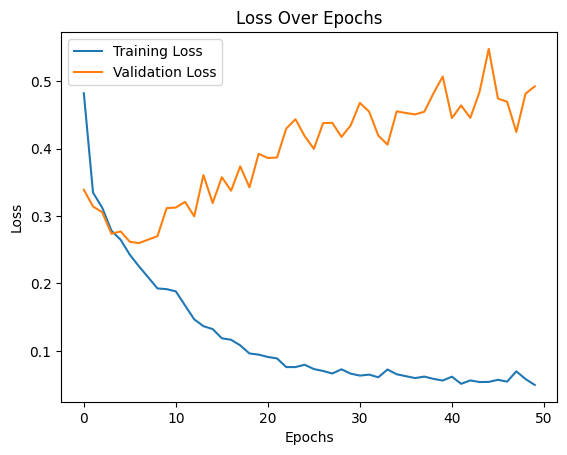

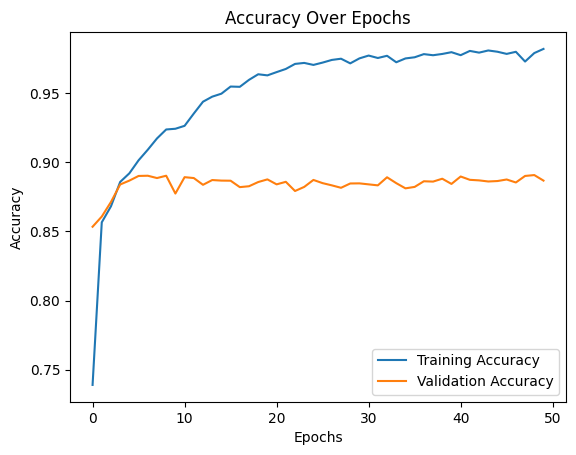

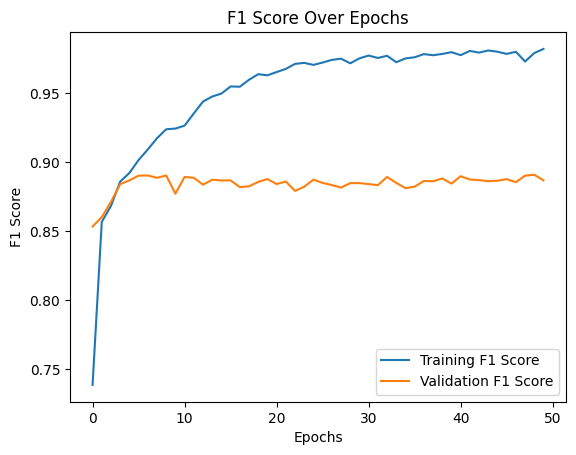

In [ ]:
Report.plot_training_history(history)

### **Classification with MLP Classifier  (previous assignment, serves as a baseline here)**

**Experiment Setup: Initial Testing with Arbitrary Hyperparameters**

In this experiment, we aim to evaluate the performance of our MLP classifier. To start, we set arbitrary hyperparameter values for the MLP classifier. This initial testing allows us to observe baseline performance and helps us identify potential adjustments for further tuning. Subsequent steps will involve tuning these parameters for optimal performance.

In [ ]:
# Step 1: Fetch and preprocess data
(X_train, y_train), (X_test, y_test), (X_dev, y_dev), avg_len = DataPreprocessor.fetch_data(num_words=10000)

# Preprocess the text data (clean and tokenize)
X_train_preprocessed = DataPreprocessor.preprocess_data(X_train)
X_test_preprocessed = DataPreprocessor.preprocess_data(X_test)
X_dev_preprocessed = DataPreprocessor.preprocess_data(X_dev)

# Step 2: Convert the preprocessed data into embeddings using the preloaded Word2Vec model
X_train_embed = DataPreprocessor.generate_embeddings(X_train_preprocessed, w2v_model)
X_test_embed = DataPreprocessor.generate_embeddings(X_test_preprocessed, w2v_model)
X_dev_embed = DataPreprocessor.generate_embeddings(X_dev_preprocessed, w2v_model)

# Step 3: Prepare dataloaders
train_loader, test_loader, dev_loader = DataPreprocessor.prepare_data_loaders(X_train_embed, X_test_embed, X_dev_embed, y_train, y_test, y_dev, batch_size=256)

Preprocessing data: 100%|██████████| 12500/12500 [01:10<00:00, 177.49it/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Model instance
model_mlp = MLPModel(input_size=w2v_model.vector_size, hidden_sizes=[512, 256], output_size=2, dropout_probs=0.5)
print(model_mlp)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizer and loss function
optimizer = Adam(model_mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Number of epochs
epochs = 50

MLPModel(
  (layers): ModuleList(
    (0): Linear(in_features=300, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (dropouts): ModuleList(
    (0-1): 2 x Dropout(p=0.5, inplace=False)
  )
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
# Train and evaluate the MLP Classifier (Before hyperparameter tuning)
test_accuracy, macro_f1 = Utils.train_and_evaluate(model_mlp, optimizer, criterion, device, epochs, train_loader, test_loader)

Epoch [1/50], Average Loss: 0.6922
Epoch [2/50], Average Loss: 0.6872
Epoch [3/50], Average Loss: 0.6786
Epoch [4/50], Average Loss: 0.6603
Epoch [5/50], Average Loss: 0.6286
Epoch [6/50], Average Loss: 0.5835
Epoch [7/50], Average Loss: 0.5249
Epoch [8/50], Average Loss: 0.4790
Epoch [9/50], Average Loss: 0.4486
Epoch [10/50], Average Loss: 0.4288
Epoch [11/50], Average Loss: 0.4066
Epoch [12/50], Average Loss: 0.4099
Epoch [13/50], Average Loss: 0.3932
Epoch [14/50], Average Loss: 0.3886
Epoch [15/50], Average Loss: 0.3740
Epoch [16/50], Average Loss: 0.3734
Epoch [17/50], Average Loss: 0.3571
Epoch [18/50], Average Loss: 0.3590
Epoch [19/50], Average Loss: 0.3430
Epoch [20/50], Average Loss: 0.3400
Epoch [21/50], Average Loss: 0.3300
Epoch [22/50], Average Loss: 0.3346
Epoch [23/50], Average Loss: 0.3255
Epoch [24/50], Average Loss: 0.3296
Epoch [25/50], Average Loss: 0.3270
Epoch [26/50], Average Loss: 0.3180
Epoch [27/50], Average Loss: 0.3034
Epoch [28/50], Average Loss: 0.3151
E

**Hyperparameter Tuning for MLP Classifier**

The hyperparameter tuning is performed using a grid search approach.

**Hyperparameters Tuned**
- **Input Size**: Dimensionality of the input data after applying dimensionality reduction.
- **Hidden Layer Sizes**: The architecture of the MLP, specifying the number of hidden layers and their sizes.
- **Dropout Probabilities**: Regularization parameter controlling the fraction of neurons dropped during training.
- **Learning Rate**: The step size for the optimizer during weight updates.

**Procedure**
1. **Data Preparation**:
   - For each configuration, the input data is reduced to a specific dimensionality, converted into tensors, and prepared using data loaders.
2. **Model Initialization**:
   - An MLP is created using the specified parameters, including input size, hidden layer sizes, and dropout probabilities.
3. **Training**:
   - The model is trained with the Adam optimizer and cross-entropy loss for a fixed number of epochs (50 epochs).
4. **Evaluation**:
   - The model is evaluated on the development set, with the macro F1 score used as the performance metric.

The best-performing set of hyperparameters is identified by iterating through all possible combinations and selecting the one that maximizes the development set's macro F1 score. The final results include the best hyperparameters and their associated performance.


In [ ]:
param_grid = {
    "hidden_sizes": [[256, 128], [512, 256], [512, 256, 128], [512, 256, 128, 64]],
    "dropout_probs": [0.2, 0.3,0.5],
    "learning_rate": [0.001, 0.01]
}

best_score = 0
best_params = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")

    # Unpack parameters
    hidden_sizes = params["hidden_sizes"]
    dropout_probs = params["dropout_probs"]
    learning_rate = params["learning_rate"]

    # Prepare Data
    train_loader, test_loader, dev_loader = DataPreprocessor.prepare_data_loaders(
        X_train_embed, X_test_embed, X_dev_embed,
        y_train, y_test, y_dev,
        batch_size=256
    )

    model = MLPModel(input_size=w2v_model.vector_size, hidden_sizes=hidden_sizes, output_size=2, dropout_probs=dropout_probs)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    dev_accuracy, dev_macroF1_score = Utils.train_and_evaluate(model, optimizer, criterion, device, epochs, train_loader, dev_loader, title='Development')

    # Update best parameters if current model is better, according to macro f1 score
    if dev_macroF1_score > best_score:
        best_score = dev_macroF1_score
        best_params = params

print(f"Best hyperparameters: {best_params}")
print(f"Best development macro f1: {best_score:.4f}")

Testing parameters: {'dropout_probs': 0.2, 'hidden_sizes': [256, 128], 'learning_rate': 0.001}
Epoch [1/50], Average Loss: 0.6919
Epoch [2/50], Average Loss: 0.6868
Epoch [3/50], Average Loss: 0.6775
Epoch [4/50], Average Loss: 0.6627
Epoch [5/50], Average Loss: 0.6413
Epoch [6/50], Average Loss: 0.6109
Epoch [7/50], Average Loss: 0.5758
Epoch [8/50], Average Loss: 0.5324
Epoch [9/50], Average Loss: 0.4923
Epoch [10/50], Average Loss: 0.4583
Epoch [11/50], Average Loss: 0.4268
Epoch [12/50], Average Loss: 0.3986
Epoch [13/50], Average Loss: 0.3943
Epoch [14/50], Average Loss: 0.3968
Epoch [15/50], Average Loss: 0.3699
Epoch [16/50], Average Loss: 0.3651
Epoch [17/50], Average Loss: 0.3651
Epoch [18/50], Average Loss: 0.3578
Epoch [19/50], Average Loss: 0.3563
Epoch [20/50], Average Loss: 0.3452
Epoch [21/50], Average Loss: 0.3518
Epoch [22/50], Average Loss: 0.3332
Epoch [23/50], Average Loss: 0.3356
Epoch [24/50], Average Loss: 0.3282
Epoch [25/50], Average Loss: 0.3263
Epoch [26/50],

The MLP classifier is trained using the best hyperparameters identified during the tuning process. The model is trained over 250 epochs using the `train_and_validate` function, which monitors performance on both the training and the validation set after each epoch.

In [ ]:
# Unpack parameters
best_hidden_sizes = best_params["hidden_sizes"]
best_dropout_probs = best_params["dropout_probs"]
best_learning_rate = best_params["learning_rate"]
best_epochs = 3

train_loader, test_loader, dev_loader = DataPreprocessor.prepare_data_loaders(
    X_train_embed, X_test_embed, X_dev_embed,
    y_train, y_test, y_dev,
    batch_size=256
)

model = MLPModel(w2v_model.vector_size, best_hidden_sizes, 2, best_dropout_probs)
print(model)
model.to(device)

optimizer = Adam(model.parameters(), lr=best_learning_rate)
criterion = nn.CrossEntropyLoss()

# Train and validate
epochs_for_val = 250
history, best_model_path = Utils.train_and_validate(model, optimizer, criterion, device, epochs_for_val, train_loader, dev_loader)
print(f"Best model saved at: {best_model_path}")

MLPModel(
  (layers): ModuleList(
    (0): Linear(in_features=300, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (dropouts): ModuleList(
    (0-2): 3 x Dropout(p=0.5, inplace=False)
  )
  (output_layer): Linear(in_features=128, out_features=2, bias=True)
)
Epoch 1/250, Training Loss: 0.4821, Accuracy: 0.7684, F1 Score: 0.7683
Validation Loss: 0.3671, Accuracy: 0.8354, F1 Score: 0.8354
Epoch 2/250, Training Loss: 0.4074, Accuracy: 0.8262, F1 Score: 0.8261
Validation Loss: 0.3792, Accuracy: 0.8313, F1 Score: 0.8303
Epoch 3/250, Training Loss: 0.3977, Accuracy: 0.8293, F1 Score: 0.8292
Validation Loss: 0.3735, Accuracy: 0.8327, F1 Score: 0.8319
Epoch 4/250, Training Loss: 0.4063, Accuracy: 0.8276, F1 Score: 0.8276
Validation Loss: 0.4367, Accuracy: 0.8073, F1 Score: 0.8038
Epoch 5/250, Training Loss: 0.4028, Accuracy: 0.8257, F1 Score: 0.8257
Validation Loss: 0.3533, Accuracy: 

**Visualization**:  
   - The training process is summarized in three performance plots:  
     - **Loss vs. Epochs**: Tracks how the training and validation loss evolve over time.  
     - **Accuracy vs. Epochs**: Shows the accuracy trends for both training and validation sets.  
     - **F1 Score vs. Epochs**: Shows the F1 score across epochs for training and validation.  

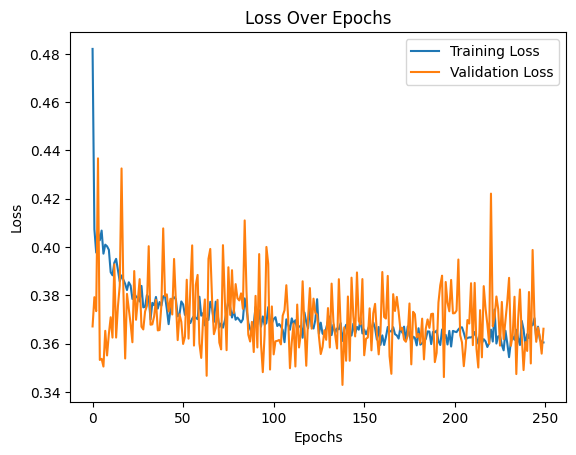

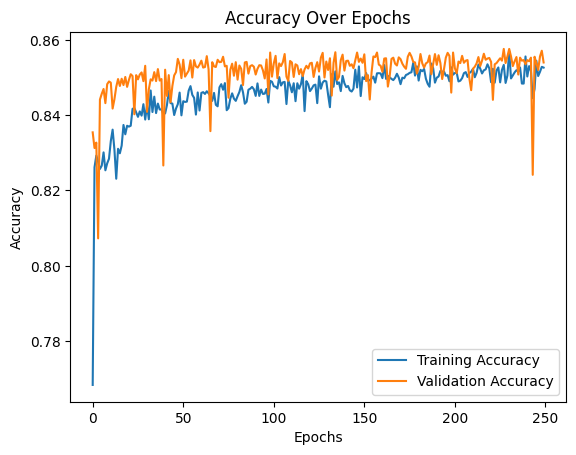

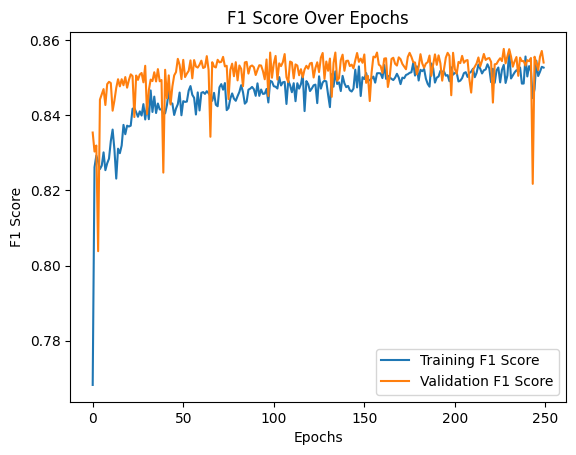

In [ ]:
Report.plot_training_history(history)

### Comparisons

In this section, we evaluate the performance of our **CNN Classifier** (using the best model and the optimal number of epochs according to validation loss, as shown in the plot above) against four baseline models:

1. **BiLSTM RNN Classifier**

2. **MLP Classifier**

3. **Majority Classifier**:  A dummy classifier from scikit-learn that always predicts the majority class observed in the training data. This serves as a simple baseline for comparison.

4. **Logistic Regression with SGD**:  A logistic regression classifier trained using stochastic gradient descent (SGD). The hyperparameters for this classifier were tuned in a previous assignment and are directly reused here without modification.

### **Stacked CNN Classifier**

In [ ]:
input_dim = 300       # Embedding dimension
n_classes = 2         # Number of classes
max_words = 30000     # Vocabulary size

# Initialize the model
model = MultikernelCNN(
    input_dim=input_dim,
    n_classes=n_classes,
    filters=best_cnn_filters,
    max_words=max_words,
    n_values=best_cnn_n_values,
    dropout_prob= best_cnn_dropout_prob,
    stacks=best_cnn_stacks,
    matrix_embeddings=torch.tensor(embedding_matrix, dtype = torch.float)
)
print(model)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
best_cnn_epochs = 5
cnn = Classifier_Wrapper(model, optimizer, criterion, device, best_cnn_epochs)
_ = cnn.fit(train_loader_rnn)

MultikernelCNN(
  (embedding_layer): Embedding(100002, 300)
  (conv_blocks): ModuleDict(
    (conv_2): ModuleList(
      (0-2): 3 x Conv1d(300, 300, kernel_size=(2,), stride=(1,), padding=same)
    )
    (conv_3): ModuleList(
      (0-2): 3 x Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=same)
    )
    (conv_4): ModuleList(
      (0-2): 3 x Conv1d(300, 300, kernel_size=(4,), stride=(1,), padding=same)
    )
  )
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (output): Linear(in_features=900, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch [1/5] - Training Loss: 0.4992
Epoch [2/5] - Training Loss: 0.3385
Epoch [3/5] - Training Loss: 0.2925
Epoch [4/5] - Training Loss: 0.2604
Epoch [5/5] - Training Loss: 0.2345


In [ ]:
y_test_cnn = cnn.predict(test_loader_rnn)
print(classification_report(y_test, y_test_cnn))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      6250
           1       0.86      0.92      0.89      6250

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



### **BiLSTM RNN Classifier (Baseline #1)**

In [ ]:
# Custom BiLSTM RNN Classifier (After hyperparameter tuning)
model_rnn = BiLSTM_Attention(
    input_dim=w2v_model.vector_size,
    n_classes=len(np.unique(y_train)),
    dropout_prob_emb=best_rnn_dropout_prob_emb,
    dropout_prob_att=best_rnn_dropout_prob_att,
    dropout_prob_out=best_rnn_dropout_prob_out,
    hidden_dim=best_rnn_hidden_dim,
    lstm_hidden_dim=best_rnn_lstm_hidden_dim,
    lstm_stacks=best_rnn_lstm_stacks,
    attention_hidden_sizes=best_rnn_attention_hidden_sizes,
    max_words=100000,
    matrix_embeddings=torch.tensor(embedding_matrix, dtype=torch.float32).to(device)
)

model_rnn.to(device)

optimizer = Adam(model_rnn.parameters(), lr=best_rnn_learning_rate)
criterion = nn.CrossEntropyLoss()
best_rnn_epochs = 5
rnn = Classifier_Wrapper(model_rnn, optimizer, criterion, device, best_rnn_epochs)
_ = rnn.fit(train_loader_rnn)

Epoch [1/5] - Training Loss: 0.5546
Epoch [2/5] - Training Loss: 0.3473
Epoch [3/5] - Training Loss: 0.3072
Epoch [4/5] - Training Loss: 0.2853
Epoch [5/5] - Training Loss: 0.2628


In [ ]:
y_test_rnn = rnn.predict(test_loader_rnn)
print(classification_report(y_test, y_test_rnn))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      6250
           1       0.91      0.86      0.88      6250

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



### **MLP Classifier (Baseline #2)**

In [ ]:
# Custom MLP Classifier (After hyperparameter tuning)
model = MLPModel(w2v_model.vector_size, [512,256], 2, 0.5)
model.to(device)
optimizer = Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
mlp = Classifier_Wrapper(model, optimizer, criterion, device, 2)
_ = mlp.fit(train_loader)

Epoch [1/2] - Training Loss: 0.4991
Epoch [2/2] - Training Loss: 0.4084


In [ ]:
y_test_mlp = mlp.predict(test_loader)
print(classification_report(y_test, y_test_mlp))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      6250
           1       0.85      0.83      0.84      6250

    accuracy                           0.84     12500
   macro avg       0.84      0.84      0.84     12500
weighted avg       0.84      0.84      0.84     12500



### **Majority Classifier (Baseline #3)**

To establish a baseline performance, we use a **majority classifier**, which always predicts the most frequent class label in the training data. This is done using `DummyClassifier` from `scikit-learn` with the `strategy="most_frequent"` parameter.

In [ ]:
# Scikit-Learn's DummyClassifier
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train_embed, y_train)

y_test_bas = baseline.predict(X_test_embed)
print(classification_report(y_test, y_test_bas))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      6250
           1       0.00      0.00      0.00      6250

    accuracy                           0.50     12500
   macro avg       0.25      0.50      0.33     12500
weighted avg       0.25      0.50      0.33     12500



### **Logistic Regression with SGD (Baseline #4)**

- Best Params:  `{'sgd__alpha': 0.00041127525951368984, 'sgd__eta0': 0.08198575356848872, 'sgd__max_iter': 500, 'sgd__n_iter_no_change': 5, 'sgd__tol': 1e-05}`

In [ ]:
best_alpha = 0.00041127525951368984
best_eta0 = 0.08198575356848872
best_max_iter = 500
best_n_iter_no_change = 5
best_tol = 1e-05

In [ ]:
# Scikit-Learn's SGDClassifier (after fine-tuning)
sgd = SGDClassifier(loss='log_loss', alpha=best_alpha, tol=best_tol, eta0=best_eta0, max_iter=best_max_iter, n_iter_no_change=best_n_iter_no_change, early_stopping=True)
sgd.fit(X_train_embed, y_train)

y_test_pred = sgd.predict(X_test_embed)
print('SGDClassifier (after fine-tuning)\n', classification_report(y_test, y_test_pred))

SGDClassifier (after fine-tuning)
               precision    recall  f1-score   support

           0       0.80      0.85      0.82      6250
           1       0.84      0.78      0.81      6250

    accuracy                           0.82     12500
   macro avg       0.82      0.82      0.82     12500
weighted avg       0.82      0.82      0.82     12500



In [ ]:
classes = np.unique(y_train)

datasets = {
    'Train': ({
        'SGDClassifier': X_train_embed,
        'DummyClassifier': X_train_embed,
        'MLPClassifier': train_loader,
        'BiLSTM_Attention': train_loader_rnn,
        'CNNClassifier': train_loader_rnn,
    }, y_train),
    'Dev': ({
        'SGDClassifier': X_dev_embed,
        'DummyClassifier': X_dev_embed,
        'MLPClassifier': dev_loader,
        'BiLSTM_Attention': val_loader_rnn,
        'CNNClassifier':val_loader_rnn
    }, y_dev),
    'Test': ({
        'SGDClassifier': X_test_embed,
        'DummyClassifier': X_test_embed,
        'MLPClassifier': test_loader,
        'BiLSTM_Attention': test_loader_rnn,
        'CNNClassifier': test_loader_rnn
    }, y_test)
}

estimators = {
    'SGDClassifier': sgd,
    'DummyClassifier': baseline,
    'MLPClassifier': mlp,
    'BiLSTM_Attention': rnn,
    'CNNClassifier': cnn
}

Report.display_metrics_scores(estimators=estimators, classes=classes, datasets=datasets)

,Classifier,Subset,Class,Macro Precision,Macro Recall,Macro F1,Macro PR-AUC,Precision,Recall,F1,PR-AUC
0,SGDClassifier,Train,Macro Average,0.826204,0.825600,0.825519,0.901780,,,,
1,SGDClassifier,Train,0,,,,,0.812164,0.847120,0.829274,0.903547
2,SGDClassifier,Train,1,,,,,0.840244,0.804080,0.821764,0.900012
3,DummyClassifier,Train,Macro Average,0.250000,0.500000,0.333333,0.750000,,,,
4,DummyClassifier,Train,0,,,,,0.500000,1.000000,0.666667,0.750000
5,DummyClassifier,Train,1,,,,,0.000000,0.000000,0.000000,0.750000
6,MLPClassifier,Train,Macro Average,0.844560,0.844560,0.844560,0.919860,,,,
7,MLPClassifier,Train,0,,,,,0.844230,0.845040,0.844635,0.922708
8,MLPClassifier,Train,1,,,,,0.844891,0.844080,0.844485,0.917012
9,BiLSTM_Attention,Train,Macro Average,0.919770,0.918680,0.918627,0.975135,,,,


,Classifier,Subset,Class,Macro Precision,Macro Recall,Macro F1,Macro PR-AUC,Precision,Recall,F1,PR-AUC
0,SGDClassifier,Dev,Macro Average,0.821151,0.819920,0.819747,0.902342,,,,
1,SGDClassifier,Dev,0,,,,,0.801266,0.850880,0.825328,0.901449
2,SGDClassifier,Dev,1,,,,,0.841037,0.788960,0.814167,0.903235
3,DummyClassifier,Dev,Macro Average,0.250000,0.500000,0.333333,0.750000,,,,
4,DummyClassifier,Dev,0,,,,,0.500000,1.000000,0.666667,0.750000
5,DummyClassifier,Dev,1,,,,,0.000000,0.000000,0.000000,0.750000
6,MLPClassifier,Dev,Macro Average,0.838596,0.838560,0.838556,0.921411,,,,
7,MLPClassifier,Dev,0,,,,,0.835128,0.843680,0.839382,0.922462
8,MLPClassifier,Dev,1,,,,,0.842063,0.833440,0.837729,0.920359
9,BiLSTM_Attention,Dev,Macro Average,0.889189,0.887840,0.887743,0.957427,,,,


,Classifier,Subset,Class,Macro Precision,Macro Recall,Macro F1,Macro PR-AUC,Precision,Recall,F1,PR-AUC
0,SGDClassifier,Test,Macro Average,0.819840,0.818160,0.817921,0.897820,,,,
1,SGDClassifier,Test,0,,,,,0.796658,0.854400,0.824519,0.897594
2,SGDClassifier,Test,1,,,,,0.843022,0.781920,0.811322,0.898046
3,DummyClassifier,Test,Macro Average,0.250000,0.500000,0.333333,0.750000,,,,
4,DummyClassifier,Test,0,,,,,0.500000,1.000000,0.666667,0.750000
5,DummyClassifier,Test,1,,,,,0.000000,0.000000,0.000000,0.750000
6,MLPClassifier,Test,Macro Average,0.840399,0.840240,0.840221,0.917299,,,,
7,MLPClassifier,Test,0,,,,,0.833046,0.851040,0.841947,0.920119
8,MLPClassifier,Test,1,,,,,0.847751,0.829440,0.838496,0.914478
9,BiLSTM_Attention,Test,Macro Average,0.887194,0.886320,0.886256,0.956674,,,,
